<a href="https://colab.research.google.com/github/benfrancis314/mental-frontiers-pub/blob/master/encode_decode_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-step and Multivariate Forecasting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# System
import os
import shutil
import time
import pickle

# Data science
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.image  as mpimg
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
tf.random.set_seed(7) # Bc luck doesn't hurt
np.random.seed(7)


## Get Data from Drive

In [0]:
drift_grat_file = open('./drive/My Drive/Colab Notebooks/drift_grat.pickle', 'rb')
drift_grat = pickle.load(drift_grat_file)
drift_grat_file.close()
df = drift_grat
df.head

<bound method NDFrame.head of                   LFP       Ch2       Ch3  ...      Ch84          Ch85      Ch86
time                                       ...                                  
5000.000243 -0.000090  0.000225  0.000223  ... -0.000050  1.170000e-06 -0.000003
5000.001043 -0.000137  0.000222  0.000215  ... -0.000062 -1.228500e-05 -0.000009
5000.001843 -0.000221  0.000234  0.000222  ... -0.000064 -2.008500e-05 -0.000019
5000.002643 -0.000306  0.000217  0.000239  ... -0.000052 -2.925000e-05 -0.000019
5000.003443 -0.000350  0.000211  0.000222  ... -0.000061 -3.783000e-05 -0.000023
...               ...       ...       ...  ...       ...           ...       ...
5349.996410  0.000012  0.000042  0.000038  ...  0.000000 -1.950000e-07 -0.000020
5349.997210 -0.000018  0.000056  0.000051  ... -0.000007  8.580000e-06 -0.000014
5349.998010 -0.000030  0.000022  0.000031  ...  0.000004  6.045000e-06 -0.000031
5349.998810 -0.000019  0.000044  0.000047  ... -0.000005 -4.875000e-06 -0.00002

#### Select Channels

In [0]:
features_considered = ['Ch50'] # Add , 'Ch51', 'Ch52'
features = df[features_considered]
features.head()

,Ch50
time,
5000.000243,0.000004
5000.001043,-0.000096
5000.001843,-0.000234
5000.002643,-0.000370
5000.003443,-0.000432


#### Verify data is imported properly

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48cc8e2fd0>],
      dtype=object)

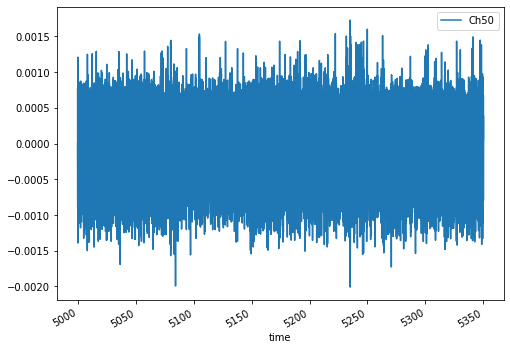

In [0]:
features.plot(subplots=True)

In [0]:
data = features.values
data.shape

(437500, 1)

In [0]:
TRAIN_SPLIT = 300000  # Training Split
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std  # Standardize again

# Sec 2
BATCH_SIZE = 32
BUFFER_SIZE = 10000

EVALUATION_INTERVAL = 200 #TRAIN_SPLT // BATCH_SIZE
EPOCHS = 5

In [0]:
def format_data(dataset, target, start_index, end_index, window_size,
                      forecast_length):
  data = []
  labels = []

  start_index = start_index + window_size
  if end_index is None:
    end_index = len(dataset) - forecast_length

  for i in range(start_index, end_index):
    indices = range(i-window_size, i)
    window = dataset[indices]
    window_plus_decoder = np.append(window, 0, 0)
    data.append(dataset[indices])
    labels.append(dataset[i:i+forecast_length])     # Or append to target, if you don't want to try to predict all the data

  return [np.array(data)], np.array(labels)

In [0]:
x_train[0].shape

(599940,)

In [0]:
# May take a moment
window_size = 30  # Past history to incorporate
forecast_length = 50  # Forecast length

x_train, y_train = format_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, window_size,
                                                 forecast_length)
x_val, y_val = format_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, window_size,
                                                 forecast_length)

# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True).repeat()

# val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_data = val_data.batch(BATCH_SIZE, drop_remainder = True).repeat()

ValueError: ignored

## TF&K Encoder Model

In [0]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
                    outputs=[Y_proba])

# ENCODER MODEL

#### Model Setup

In [0]:
# keras.backend.clear_session()

layers = [35, 35] # Number of hidden neurons in each layer of the encoder and decoder

learning_rate = 0.01
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step. In this case a 1D signal.
num_output_features = 1 # The dimensionality of the output at each time step. In this case a 1D signal.
# There is no reason for the input sequence to be of same dimension as the ouput sequence.
# For instance, using 3 input signals: consumer confidence, inflation and house prices to predict the future house prices.

loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 32 # 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 3 # 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

In [0]:
for i in layers:
  print(1)

#### Encoder

In [0]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

#### Decoder

In [0]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

#### Run Model

In [0]:
# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer=optimiser, loss=loss)

In [0]:
# random_sine returns a generator that produces batches of training samples ([encoder_input, decoder_input], decoder_output)
# You can play with the min max frequencies of the sine waves, the number of sine waves that are summed etc...
# Another interesing exercise could be to see whether the model generalises well on sums of 3 signals if it's only been
# trained on sums of 2 signals...
train_data_generator = data_gen(data=data,batch_size=batch_size,
                                   steps_per_epoch=steps_per_epoch,
                                   input_sequence_length=input_sequence_length,
                                   target_sequence_length=target_sequence_length)


##### Study the following process for getting data ready

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
model.fit(train_data_generator, verbose=0, steps_per_epoch=steps_per_epoch, epochs=epochs)

In [0]:
def random_sine(batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length,
                min_frequency=0.1, max_frequency=10,
                min_amplitude=0.1, max_amplitude=1,
                min_offset=-0.5, max_offset=0.5,
                num_signals=3, seed=43):
    """Produce a batch of signals.

    The signals are the sum of randomly generated sine waves.

    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    min_frequency: Minimum frequency of the base signals that are summed.
    max_frequency: Maximum frequency of the base signals that are summed.
    min_amplitude: Minimum amplitude of the base signals that are summed.
    max_amplitude: Maximum amplitude of the base signals that are summed.
    min_offset: Minimum offset of the base signals that are summed.
    max_offset: Maximum offset of the base signals that are summed.
    num_signals: Number of signals that are summed together.
    seed: The seed used for generating random numbers
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

    while True:
        # Reset seed to obtain same sequences from epoch to epoch
        np.random.seed(seed)

        for _ in range(steps_per_epoch):
            signals = np.zeros((batch_size, num_points))
            for _ in range(num_signals):
                # Generate random amplitude, frequence, offset, phase 
                amplitude = (np.random.rand(batch_size, 1) * 
                            (max_amplitude - min_amplitude) +
                             min_amplitude)
                frequency = (np.random.rand(batch_size, 1) * 
                            (max_frequency - min_frequency) + 
                             min_frequency)
                offset = (np.random.rand(batch_size, 1) * 
                         (max_offset - min_offset) + 
                          min_offset)
                phase = np.random.rand(batch_size, 1) * 2 * np.pi 
                         

                signals += amplitude * np.sin(frequency * x + phase)
            signals = np.expand_dims(signals, axis=2)
            
            encoder_input = signals[:, :input_sequence_length, :]
            decoder_output = signals[:, input_sequence_length:, :]
            
            # The output of the generator must be ([encoder_input, decoder_input], [decoder_output])
            decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
            yield ([encoder_input, decoder_input], decoder_output)

In [0]:
def data_gen(data, batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length):
    """Produce a batch of signals.

    The signals are the sum of randomly generated sine waves.

    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    d = data[:,0]   # Remove a "1" from the data shape
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

    while True:
       for j in range(0,steps_per_epoch+0):  # Each step per epoch

        batch_data = np.zeros((batch_size, num_points))
        for i in range(1,(batch_size+1)):
          window = d[(-(num_points)-i-(steps_per_epoch*j)):-(i+steps_per_epoch*j)]

          print(window)
          batch_data[i-1,:] = window


        batch_data = np.expand_dims(batch_data, axis=2)
        # print(batch_data)

        encoder_input = batch_data[:, :input_sequence_length, :]
        decoder_output = batch_data[:, input_sequence_length:, :]
        decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
        yield ([encoder_input, decoder_input], decoder_output)

In [0]:
batch_size = 2    # 512
steps_per_epoch = 2 # 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 15 # Length of the sequence used by the encoder
target_sequence_length = 15 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model

d = data[:,0]   # Remove a "1" from the data shape
num_points = input_sequence_length + target_sequence_length

for j in range(0,steps_per_epoch+0):  # Each step per epoch

  batch_data = np.zeros((batch_size, num_points))
  for i in range(1,(batch_size+1)):
    window = d[(-(num_points)-i-(steps_per_epoch*j)):-(i+steps_per_epoch*j)]

    print(window)
    batch_data[i-1,:] = window


  batch_data = np.expand_dims(batch_data, axis=2)
  # print(batch_data)

  encoder_input = batch_data[:, :input_sequence_length, :]
  decoder_output = batch_data[:, input_sequence_length:, :]
  decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
  # print(encoder_input)
  # print(decoder_output)
  # print(decoder_input.shape)

[-4.2958499e-04 -3.6406500e-04 -3.0634500e-04 -2.7222000e-04
 -2.3399999e-04 -1.5912000e-04 -1.1524500e-04 -1.0257000e-04
 -7.5270000e-05 -1.2304500e-04 -1.4859000e-04 -1.1524500e-04
 -8.5214997e-05 -6.8250001e-06  5.3820000e-05  9.1454996e-05
  1.3825500e-04  2.2717500e-04  3.0965998e-04  3.5490000e-04
  3.9175499e-04  3.2682001e-04  2.4121499e-04  1.7510999e-04
  1.0413000e-04  1.1836500e-04  1.1056500e-04  5.6745001e-05
  4.7385001e-05  6.3569998e-05]
[-4.7638500e-04 -4.2958499e-04 -3.6406500e-04 -3.0634500e-04
 -2.7222000e-04 -2.3399999e-04 -1.5912000e-04 -1.1524500e-04
 -1.0257000e-04 -7.5270000e-05 -1.2304500e-04 -1.4859000e-04
 -1.1524500e-04 -8.5214997e-05 -6.8250001e-06  5.3820000e-05
  9.1454996e-05  1.3825500e-04  2.2717500e-04  3.0965998e-04
  3.5490000e-04  3.9175499e-04  3.2682001e-04  2.4121499e-04
  1.7510999e-04  1.0413000e-04  1.1836500e-04  1.1056500e-04
  5.6745001e-05  4.7385001e-05]
[[[-4.29584994e-04]
  [-3.64064996e-04]
  [-3.06344999e-04]
  [-2.72220001e-04]
  

In [0]:
for i in range(1,(batch_size+1)):
  x = i
batch_data = np.zeros((batch_size, num_points))
batch_data[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

# SAVE BEFORE EXITING

### Save Model

In [0]:
# Save the weights, model
# model.save_weights('./checkpoints/lstm_32x32_fc_len_1_epochs_10') # Save weights
model.save('./drive/My Drive/Colab Notebooks/saved_models/drift_grat') # Save model

NameError: ignored

### Save Best Results

In [0]:
output = open('./drive/My Drive/Colab Notebooks/best_results.pkl', 'wb')
pickle.dump(best_results, output)
output.close()


## Functions

In [0]:
def random_sine(batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length,
                min_frequency=0.1, max_frequency=10,
                min_amplitude=0.1, max_amplitude=1,
                min_offset=-0.5, max_offset=0.5,
                num_signals=3, seed=43):
    """Produce a batch of signals.

    The signals are the sum of randomly generated sine waves.

    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    min_frequency: Minimum frequency of the base signals that are summed.
    max_frequency: Maximum frequency of the base signals that are summed.
    min_amplitude: Minimum amplitude of the base signals that are summed.
    max_amplitude: Maximum amplitude of the base signals that are summed.
    min_offset: Minimum offset of the base signals that are summed.
    max_offset: Maximum offset of the base signals that are summed.
    num_signals: Number of signals that are summed together.
    seed: The seed used for generating random numbers
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

    while True:
        # Reset seed to obtain same sequences from epoch to epoch
        np.random.seed(seed)

        for _ in range(steps_per_epoch):
            signals = np.zeros((batch_size, num_points))
            for _ in range(num_signals):
                # Generate random amplitude, frequence, offset, phase 
                amplitude = (np.random.rand(batch_size, 1) * 
                            (max_amplitude - min_amplitude) +
                             min_amplitude)
                frequency = (np.random.rand(batch_size, 1) * 
                            (max_frequency - min_frequency) + 
                             min_frequency)
                offset = (np.random.rand(batch_size, 1) * 
                         (max_offset - min_offset) + 
                          min_offset)
                phase = np.random.rand(batch_size, 1) * 2 * np.pi 
                         

                signals += amplitude * np.sin(frequency * x + phase)
            signals = np.expand_dims(signals, axis=2)
            
            encoder_input = signals[:, :input_sequence_length, :]
            decoder_output = signals[:, input_sequence_length:, :]
            
            # The output of the generator must be ([encoder_input, decoder_input], [decoder_output])
            decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
            yield ([encoder_input, decoder_input], decoder_output)

def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.
    
    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """

    plt.figure(figsize=(12, 3))

    output_dim = x.shape[-1]
    for j in range(output_dim):
        past = x[:, j] 
        true = y_true[:, j]
        pred = y_pred[:, j]

        label1 = "Seen (past) values" if j==0 else "_nolegend_"
        label2 = "True future values" if j==0 else "_nolegend_"
        label3 = "Predictions" if j==0 else "_nolegend_"

        plt.plot(range(len(past)), past, "o--b",
                 label=label1)
        plt.plot(range(len(past),
                 len(true)+len(past)), true, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y",
                 label=label3)
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

# if __name__ == '__main__':

#     # This is an example of the plot function and the signal generator
#     from matplotlib import pyplot as plt
#     gen = random_sine(3, 3, 15, 15)
#     for i, data in enumerate(gen):
#         input_seq, output_seq = data
#         for j in range(input_seq.shape[0]):
#             plot_prediction(input_seq[j, :, :],
#                             output_seq[j, :, :],
#                             output_seq[j, :, :])
#         if i > 2:
#             break

In [0]:
def data_gen(data, batch_size, steps_per_epoch,
                input_sequence_length, target_sequence_length):
    """Produce a batch of signals.

    The signals are the sum of randomly generated sine waves.

    Arguments
    ---------
    batch_size: Number of signals to produce.
    steps_per_epoch: Number of batches of size batch_size produced by the
        generator.
    input_sequence_length: Length of the input signals to produce.
    target_sequence_length: Length of the target signals to produce.
    
    Returns
    -------
    signals: 2D array of shape (batch_size, sequence_length)
    """
    d = data[:,0]   # Remove a "1" from the data shape
    num_points = input_sequence_length + target_sequence_length
    x = np.arange(num_points) * 2*np.pi/30

    # while True:
    for j in range(0,steps_per_epoch+0):  # Each step per epoch

      batch_data = np.zeros((batch_size, num_points))
      for i in range(1,(batch_size+1)):
        window = d[(-(num_points)-i-(steps_per_epoch*j)):-(i+steps_per_epoch*j)]

        print(window)
        batch_data[i-1,:] = window


      batch_data = np.expand_dims(batch_data, axis=2)
      # print(batch_data)

      encoder_input = batch_data[:, :input_sequence_length, :]
      decoder_output = batch_data[:, input_sequence_length:, :]
      decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], 1))
      yield ([encoder_input, decoder_input], decoder_output)